<a href="https://colab.research.google.com/github/marwahfaraj/Smart-Water-Quality-Monitoring-Using-IoT-and-Machine-Learning/blob/suryaWaterPrediction/notebooks/04_water_quality_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water Quality Predection Model

## AAI-530 Final Project - Machine Learning Method 3

This notebook implements a machine learning predection model to predict water quality status (Safe/Warning/Unsafe) based on sensor readings.

**Objective**: Predict water quality status using multiple sensor inputs




In [1]:
# !git clone https://github.com/marwahfaraj/Smart-Water-Quality-Monitoring-Using-IoT-and-Machine-Learning.git

Cloning into 'Smart-Water-Quality-Monitoring-Using-IoT-and-Machine-Learning'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 76 (delta 13), reused 59 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 31.02 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [45]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.layers import GRU, Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Prepare Data

In [50]:
# Load raw data and preprocess (if processed data not available)
# DATA_DIR = "/content/Smart-Water-Quality-Monitoring-Using-IoT-and-Machine-Learning/outputs/water_quality_processed.csv"
DATA_DIR = '../outputs/water_quality_processed.csv'

# Load data
df = pd.read_csv(DATA_DIR)

print(f"Loaded {len(df):,} records from {df['Station'].nunique()} stations")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}\n")

print(df.head())

Loaded 295,754 records from 11 stations
Date range: 2016-03-01 00:00:00 to 2020-04-01 23:00:00

             Timestamp   Q  Conductivity  NO3  Temp  Turbidity  Level  \
0  2017-05-11 14:00:00 NaN      13502.10  NaN   NaN      12.79    NaN   
1  2017-05-11 15:00:00 NaN      10304.00  NaN   NaN      11.93    NaN   
2  2017-05-11 16:00:00 NaN       5588.08  NaN   NaN      10.34    NaN   
3  2017-05-11 17:00:00 NaN      13937.00  NaN   NaN      24.02    NaN   
4  2017-05-11 18:00:00 NaN      44761.40  NaN   NaN      18.46    NaN   

   Dayofweek  Month                         Station  ...  \
0          3      5  Johnstone River Coquette Point  ...   
1          3      5  Johnstone River Coquette Point  ...   
2          3      5  Johnstone River Coquette Point  ...   
3          3      5  Johnstone River Coquette Point  ...   
4          3      5  Johnstone River Coquette Point  ...   

   Turbidity_rolling_mean_12h Turbidity_rolling_std_12h  \
0                   12.790000                

In [29]:
df.columns

Index(['Timestamp', 'Q', 'Conductivity', 'NO3', 'Temp', 'Turbidity', 'Level',
       'Dayofweek', 'Month', 'Station', 'Hour', 'Quality_Status', 'Year',
       'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'IsWeekend', 'Hour_sin',
       'Hour_cos', 'Month_sin', 'Month_cos', 'Turbidity_lag_1h',
       'Turbidity_lag_6h', 'Turbidity_lag_12h', 'Turbidity_lag_24h',
       'Conductivity_lag_1h', 'Conductivity_lag_6h', 'Conductivity_lag_12h',
       'Conductivity_lag_24h', 'Turbidity_rolling_mean_6h',
       'Turbidity_rolling_std_6h', 'Turbidity_rolling_mean_12h',
       'Turbidity_rolling_std_12h', 'Turbidity_rolling_mean_24h',
       'Turbidity_rolling_std_24h', 'Conductivity_rolling_mean_6h',
       'Conductivity_rolling_std_6h', 'Conductivity_rolling_mean_12h',
       'Conductivity_rolling_std_12h', 'Conductivity_rolling_mean_24h',
       'Conductivity_rolling_std_24h'],
      dtype='object')

## 2. Feature Selection and Sequence Creation

In [30]:
target_col = "Turbidity"
drop_cols = [
    "Timestamp",
    "Quality_Status",
    "Turbidity",
    "Dayofweek",
    "Month",
    "Hour",
    "DayOfWeek",
]

feature_cols = [c for c in df.columns if c not in drop_cols]
print("Num candidate features:", len(feature_cols))
print(feature_cols)


Num candidate features: 34
['Q', 'Conductivity', 'NO3', 'Temp', 'Level', 'Station', 'Year', 'DayOfMonth', 'WeekOfYear', 'IsWeekend', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Turbidity_lag_1h', 'Turbidity_lag_6h', 'Turbidity_lag_12h', 'Turbidity_lag_24h', 'Conductivity_lag_1h', 'Conductivity_lag_6h', 'Conductivity_lag_12h', 'Conductivity_lag_24h', 'Turbidity_rolling_mean_6h', 'Turbidity_rolling_std_6h', 'Turbidity_rolling_mean_12h', 'Turbidity_rolling_std_12h', 'Turbidity_rolling_mean_24h', 'Turbidity_rolling_std_24h', 'Conductivity_rolling_mean_6h', 'Conductivity_rolling_std_6h', 'Conductivity_rolling_mean_12h', 'Conductivity_rolling_std_12h', 'Conductivity_rolling_mean_24h', 'Conductivity_rolling_std_24h']


In [31]:
df_featureSelection = df.sort_values("Timestamp").reset_index(drop=True).copy()

n = len(df_featureSelection)
train_end = int(n*0.7)
val_end = int(n*0.85)

train_df = df_featureSelection.iloc[:train_end]
val_df = df_featureSelection.iloc[train_end:val_end]
test_df = df_featureSelection.iloc[val_end:]

print("Total n:", n)
print("Length of train_df:", len(train_df))
print("Length of val_df:", len(val_df))
print("Length of test_df:", len(test_df))

Total n: 295754
Length of train_df: 207027
Length of val_df: 44363
Length of test_df: 44364


In [7]:
# Cleaning the data set for NA values.
train_clean = train_df.dropna(subset=[target_col]).copy()

X_train = train_clean[feature_cols].copy()

# hot encoding the column values because some columns may contain
# string values, where RFR will accept only the numerical values.
X_train = pd.get_dummies(X_train, drop_first=True)
y_train = train_clean[target_col].values

rf = RandomForestRegressor(
    n_estimators=80,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.8min finished


In [8]:
# Top 20 features
importances.head(20)


,0
Turbidity_rolling_mean_6h,0.742123
Turbidity_lag_1h,0.147415
Turbidity_rolling_std_6h,0.021037
Turbidity_lag_24h,0.014720
Q,0.012781
Turbidity_rolling_std_12h,0.009229
Level,0.005743
Turbidity_lag_12h,0.004128
Conductivity,0.004072
Conductivity_lag_1h,0.003897


In [9]:
top_k = 20
top_features = importances.head(top_k).index.tolist()
top_features

['Turbidity_rolling_mean_6h',
 'Turbidity_lag_1h',
 'Turbidity_rolling_std_6h',
 'Turbidity_lag_24h',
 'Q',
 'Turbidity_rolling_std_12h',
 'Level',
 'Turbidity_lag_12h',
 'Conductivity',
 'Conductivity_lag_1h',
 'Turbidity_lag_6h',
 'Turbidity_rolling_mean_12h',
 'Conductivity_rolling_std_6h',
 'Turbidity_rolling_std_24h',
 'Conductivity_lag_6h',
 'Conductivity_lag_12h',
 'Turbidity_rolling_mean_24h',
 'Conductivity_lag_24h',
 'Conductivity_rolling_std_12h',
 'Hour_cos']

In [10]:
# Remove redundant features

corr = train_df[top_features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col]> 0.95)]
final_features = [f for f in top_features if f not in to_drop]

print("Dropped due to high correlation:", to_drop)
print("Final Features:", final_features)

Dropped due to high correlation: ['Turbidity_lag_1h', 'Conductivity_lag_1h', 'Turbidity_rolling_mean_12h', 'Turbidity_rolling_mean_24h', 'Conductivity_lag_24h']
Final Features: ['Turbidity_rolling_mean_6h', 'Turbidity_rolling_std_6h', 'Turbidity_lag_24h', 'Q', 'Turbidity_rolling_std_12h', 'Level', 'Turbidity_lag_12h', 'Conductivity', 'Turbidity_lag_6h', 'Conductivity_rolling_std_6h', 'Turbidity_rolling_std_24h', 'Conductivity_lag_6h', 'Conductivity_lag_12h', 'Conductivity_rolling_std_12h', 'Hour_cos']


In [11]:
print(len(top_features), "->", len(final_features))
print("Any non-numeric in final_features?",
      train_df[final_features].select_dtypes(include=["object"]).columns.tolist())

20 -> 15
Any non-numeric in final_features? []


## 3. Sequence Creation

In [32]:
df_model = df.sort_values("Timestamp").reset_index(drop=True).copy()

df_model = df_model[["Timestamp"] + final_features + [target_col]].copy()
df_model = df_model.dropna(subset=final_features+ [target_col]).reset_index(drop=True)

print(f"dfModel Rows: ", len(df_model))

dfModel Rows:  80227


In [35]:
X = df_model[final_features]
y = df_model[[target_col]]

n = len(df_model)
train_end = int(n*0.7)
val_end = int(n*0.85)

X_train_raw, y_train_raw = X[:train_end], y[:train_end]
X_val_raw,   y_val_raw   = X[train_end:val_end], y[train_end:val_end]
X_test_raw,  y_test_raw  = X[val_end:], y[val_end:]

scaler_X = MinMaxScaler().fit(X_train_raw)
scaler_y = MinMaxScaler().fit(y_train_raw)

X_train_s = scaler_X.transform(X_train_raw)
X_val_s   = scaler_X.transform(X_val_raw)
X_test_s  = scaler_X.transform(X_test_raw)

y_train_s = scaler_y.transform(y_train_raw)
y_val_s   = scaler_y.transform(y_val_raw)
y_test_s  = scaler_y.transform(y_test_raw)

In [37]:
def create_sequences(X, y, seq_len):
  Xs,ys = [],[]
  for i in range(len(X) - seq_len):
    Xs.append(X[i:i+seq_len])
    ys.append(y[i+seq_len])
  return np.array(Xs), np.array(ys)

SEQUENCE_LENGTH = 24

X_train, y_train = create_sequences(X_train_s, y_train_s, SEQUENCE_LENGTH)
X_val,   y_val   = create_sequences(X_val_s,   y_val_s,   SEQUENCE_LENGTH)
X_test,  y_test  = create_sequences(X_test_s,  y_test_s,  SEQUENCE_LENGTH)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (56134, 24, 15) (56134, 1)
Val  : (12010, 24, 15) (12010, 1)
Test : (12011, 24, 15) (12011, 1)


## 4. GRU Model

In [39]:
def build_gru_model(sequence_length, n_features, units_1=64, units_2=32, dropout_rate=0.2, lr=0.001):
    """
    GRU model for time series regression (predict Turbidity).
    Input shape: (sequence_length, n_features)
    Output: single value (next turbidity)
    """
    model = Sequential([
        Input(shape=(sequence_length, n_features)),

        GRU(units_1, return_sequences=True),
        Dropout(dropout_rate),

        GRU(units_2, return_sequences=False),
        Dropout(dropout_rate),

        Dense(16, activation='relu'),
        Dense(1)  # regression output
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


In [40]:
BATCH_SIZE = 64
EPOCHS = 50

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

gru_model = build_gru_model(SEQUENCE_LENGTH, X_train.shape[2], units_1=64, units_2=32, dropout_rate=0.2, lr=0.001)

gru_model.summary()

gru_history = gru_model.fit(
    X_train, y_train,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,505 (99.63 KB)

 Trainable params: 25,505 (99.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0059 - mae: 0.0501 - val_loss: 0.0041 - val_mae: 0.0374 - learning_rate: 0.0010
Epoch 2/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0044 - mae: 0.0421 - val_loss: 0.0041 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 3/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0045 - mae: 0.0417 - val_loss: 0.0038 - val_mae: 0.0422 - learning_rate: 0.0010
Epoch 4/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0042 - mae: 0.0407 - val_loss: 0.0040 - val_mae: 0.0448 - learning_rate: 0.0010
Epoch 5/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0043 - mae: 0.0406 - val_loss: 0.0041 - val_mae: 0.0448 - learning_rate: 0.0010
Epoch 6/50
876/878 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0407
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
878/878 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0043 - mae: 0.0407 - val_loss: 0.0038 - val_mae: 0.0400 - learning_rate: 0.0010
E

In [48]:
def smape(y_true, y_pred, eps=1e-8):
    denom = (np.abs(y_true) + np.abs(y_pred) + eps)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def safe_mape(y_true, y_pred, eps=1e-6):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100

def print_metrics(label, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_v  = safe_mape(y_true, y_pred)
    smape_v = smape(y_true, y_pred)

    print(f"{label} MSE  : {mse:.4f}")
    print(f"{label} RMSE : {rmse:.4f}")
    print(f"{label} MAE  : {mae:.4f}")
    print(f"{label} R²   : {r2:.4f}")
    print(f"{label} MAPE : {mape_v:.2f}%")
    print(f"{label} sMAPE: {smape_v:.2f}%")

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "mape": mape_v, "smape": smape_v}

def evaluate_gru_with_diagnostics(
    model,
    X,
    y_scaled,
    scaler_y,
    label="VAL",
    plot_points=300,
    rolling_window=50,
    tail_quantile=0.90
):
    """
    X: 3D sequences  (n_samples, seq_len, n_features)
    y_scaled: scaled targets aligned with X (n_samples, 1) or (n_samples,)
    scaler_y: MinMaxScaler fitted on TRAIN target only
    """

    # ---- Predict (scaled) ----
    y_pred_scaled = model.predict(X, verbose=0)

    # ---- Ensure 2D for inverse_transform ----
    y_scaled_2d = y_scaled.reshape(-1, 1) if y_scaled.ndim == 1 else y_scaled

    # ---- Inverse transform to original units ----
    y_true = scaler_y.inverse_transform(y_scaled_2d).ravel()
    y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()

    print("\n" + "=" * 60)
    print(f"Evaluation: {label}")
    print("=" * 60)

    model_metrics = print_metrics(f"{label} (GRU)", y_true, y_pred)

    if len(y_true) >= 2:
        y_true_b = y_true[1:]
        y_pred_baseline = y_true[:-1]  # previous true value
        baseline_metrics = print_metrics(f"{label} (Baseline: y[t-1])", y_true_b, y_pred_baseline)

        print("\nImprovement vs baseline (positive is better for error metrics):")
        print(f"MAE : {baseline_metrics['mae']  - model_metrics['mae']:.4f}")
        print(f"RMSE: {baseline_metrics['rmse'] - model_metrics['rmse']:.4f}")
    else:
        baseline_metrics = None
        print(f"{label}: Not enough points for baseline comparison.")

    # ---- Residual diagnostics ----
    resid = y_true - y_pred
    abs_err = np.abs(resid)

    # Tail (spikes) metrics
    q = np.quantile(y_true, tail_quantile)
    mask = y_true >= q
    if np.any(mask):
        tail_mae = mean_absolute_error(y_true[mask], y_pred[mask])
        tail_rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
        print(f"\n{label} Tail (>= {tail_quantile:.0%} quantile, threshold={q:.4f})")
        print(f"{label} Tail MAE : {tail_mae:.4f}")
        print(f"{label} Tail RMSE: {tail_rmse:.4f}")

    # Rolling MAE (drift view)
    if len(abs_err) >= rolling_window:
        roll_mae = np.convolve(abs_err, np.ones(rolling_window)/rolling_window, mode="valid")
    else:
        roll_mae = None

    # --------------------------
    # Plots
    # --------------------------
    # 1) Actual vs Predicted
    plt.figure(figsize=(12, 4))
    nplot = min(plot_points, len(y_true))
    plt.plot(y_true[:nplot], label="Actual")
    plt.plot(y_pred[:nplot], label="Predicted")
    plt.title(f"{label}: Actual vs Predicted Turbidity (first {nplot} points)")
    plt.xlabel("Time Step")
    plt.ylabel("Turbidity")
    plt.legend()
    plt.show()

    # 2) Residuals over time
    plt.figure(figsize=(12, 4))
    nplot = min(max(plot_points, 500), len(resid))
    plt.plot(resid[:nplot])
    plt.title(f"{label}: Residuals (true - pred) (first {nplot} points)")
    plt.xlabel("Time Step")
    plt.ylabel("Residual")
    plt.show()

    # 3) Residual histogram
    plt.figure(figsize=(6, 4))
    plt.hist(resid, bins=40)
    plt.title(f"{label}: Residual Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.show()

    # 4) |Error| vs True (heteroscedasticity)
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, abs_err, s=8, alpha=0.5)
    plt.title(f"{label}: |Error| vs True Turbidity")
    plt.xlabel("True Turbidity")
    plt.ylabel("|Error|")
    plt.show()

    # 5) Rolling MAE
    if roll_mae is not None:
        plt.figure(figsize=(12, 4))
        plt.plot(roll_mae)
        plt.title(f"{label}: Rolling MAE (window={rolling_window})")
        plt.xlabel("Time Step")
        plt.ylabel("Rolling MAE")
        plt.show()

    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "metrics_gru": model_metrics,
        "metrics_baseline": baseline_metrics,
        "residuals": resid
    }


Evaluation: VAL
VAL (GRU) MSE  : 3048.3760
VAL (GRU) RMSE : 55.2121
VAL (GRU) MAE  : 36.6159
VAL (GRU) R²   : 0.2006
VAL (GRU) MAPE : 729.76%
VAL (GRU) sMAPE: 129.98%
VAL (Baseline: y[t-1]) MSE  : 8422.5217
VAL (Baseline: y[t-1]) RMSE : 91.7743
VAL (Baseline: y[t-1]) MAE  : 51.8537
VAL (Baseline: y[t-1]) R²   : -1.2087
VAL (Baseline: y[t-1]) MAPE : 977.84%
VAL (Baseline: y[t-1]) sMAPE: 104.30%

Improvement vs baseline (positive is better for error metrics):
MAE : 15.2377
RMSE: 36.5622

VAL Tail (>= 90% quantile, threshold=120.5687)
VAL Tail MAE : 120.4880
VAL Tail RMSE: 130.9314


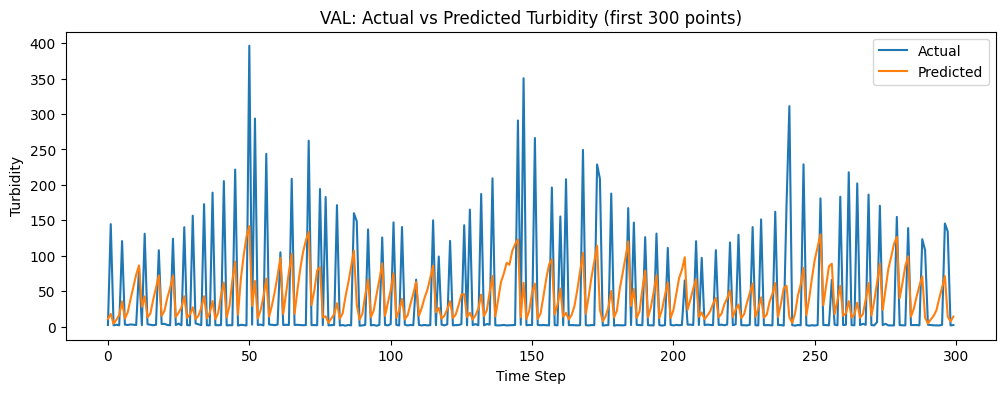

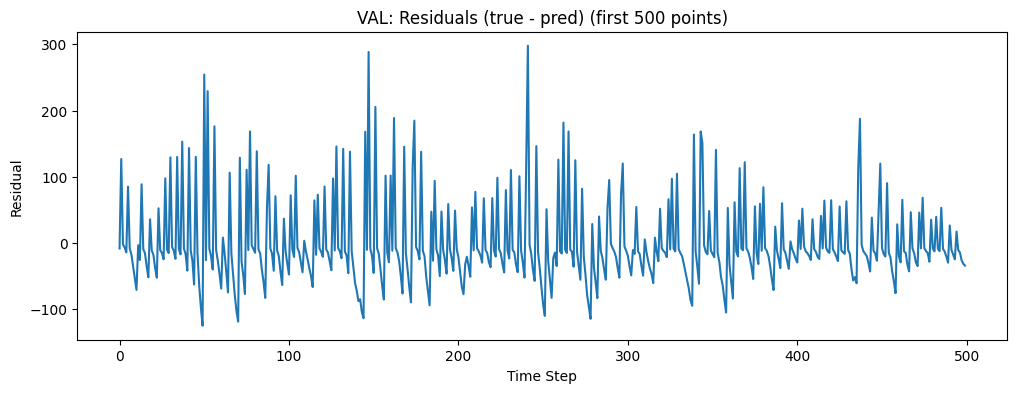

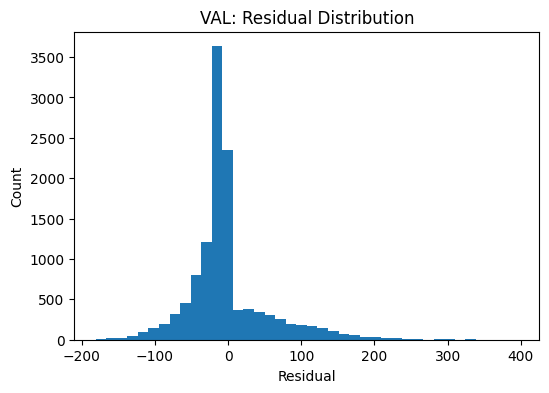

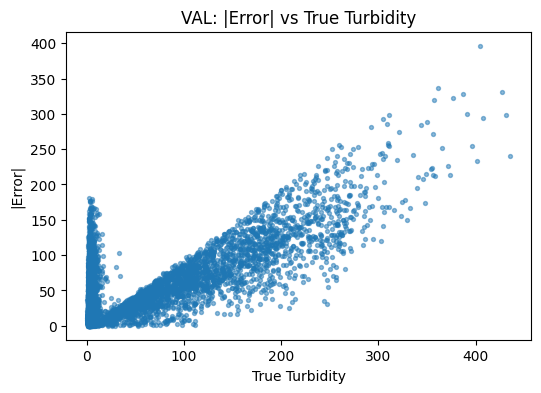

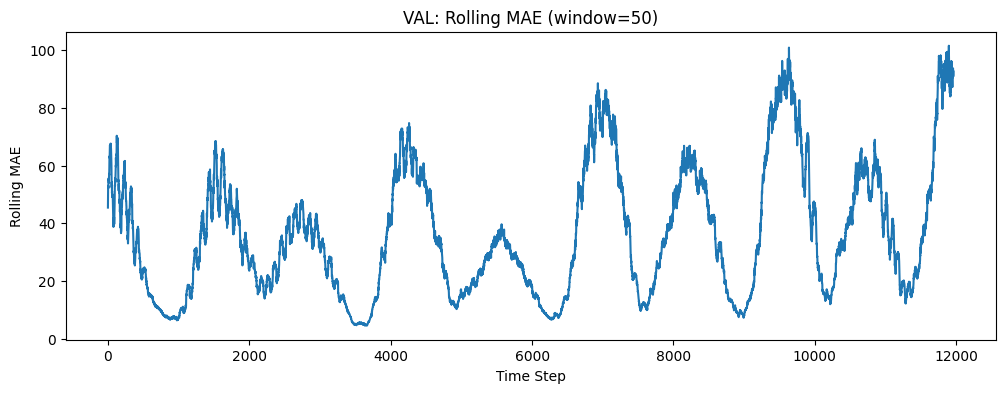


Evaluation: TEST
TEST (GRU) MSE  : 4937.2077
TEST (GRU) RMSE : 70.2653
TEST (GRU) MAE  : 38.7460
TEST (GRU) R²   : 0.1105
TEST (GRU) MAPE : 435.06%
TEST (GRU) sMAPE: 97.96%
TEST (Baseline: y[t-1]) MSE  : 11509.3945
TEST (Baseline: y[t-1]) RMSE : 107.2818
TEST (Baseline: y[t-1]) MAE  : 57.3469
TEST (Baseline: y[t-1]) R²   : -1.0735
TEST (Baseline: y[t-1]) MAPE : 611.88%
TEST (Baseline: y[t-1]) sMAPE: 104.99%

Improvement vs baseline (positive is better for error metrics):
MAE : 18.6009
RMSE: 37.0166

TEST Tail (>= 90% quantile, threshold=125.1500)
TEST Tail MAE : 146.4580
TEST Tail RMSE: 190.0198


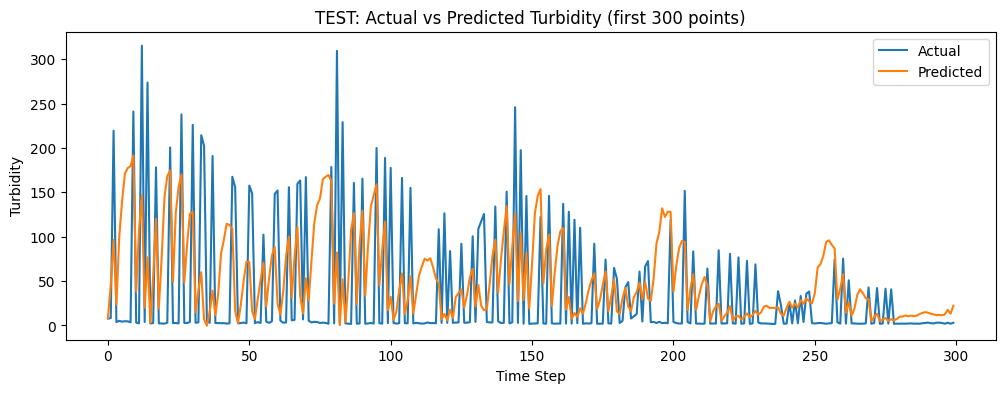

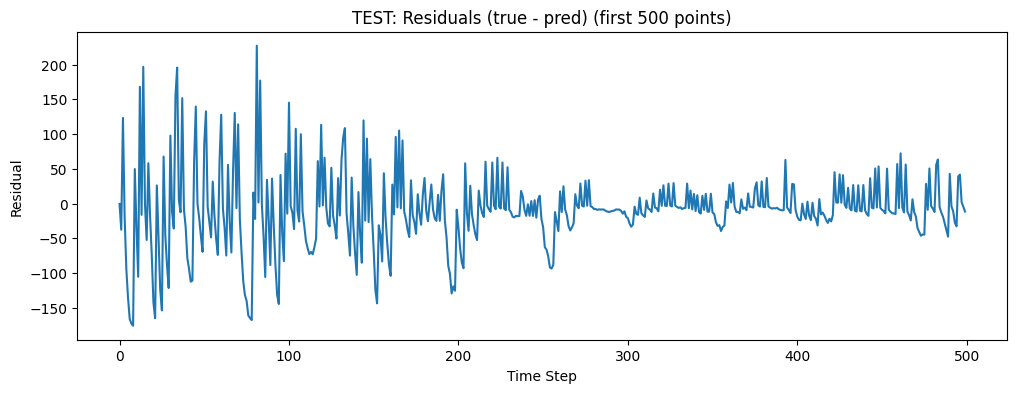

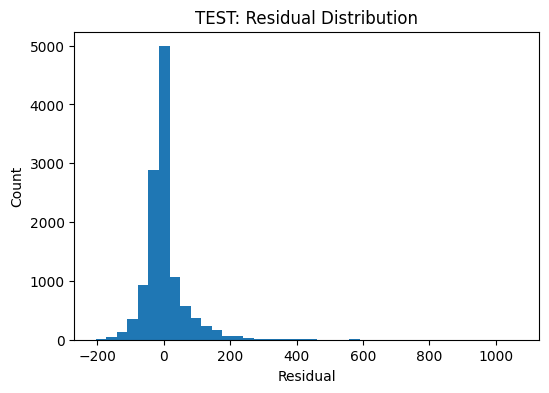

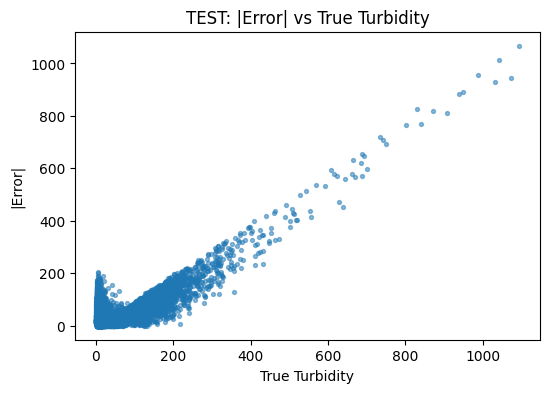

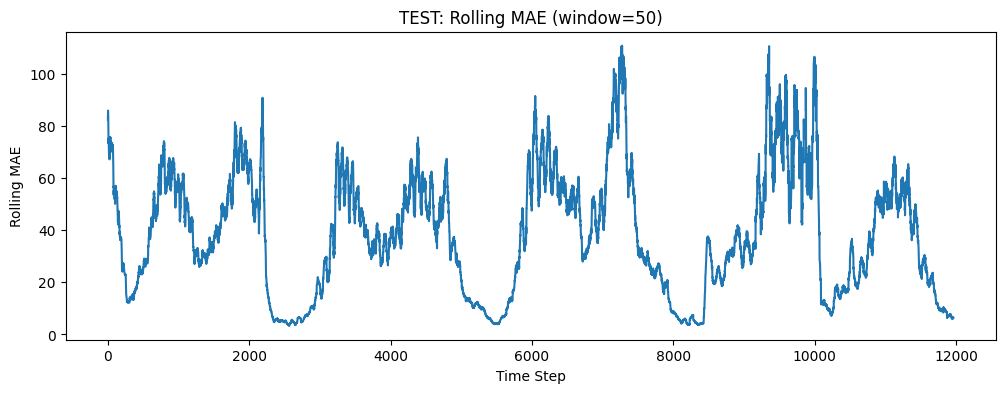

In [49]:
val_results = evaluate_gru_with_diagnostics(
    model=gru_model,
    X=X_val,
    y_scaled=y_val,
    scaler_y=scaler_y,
    label="VAL",
    plot_points=300,
    rolling_window=50,
    tail_quantile=0.90
)

test_results = evaluate_gru_with_diagnostics(
    model=gru_model,
    X=X_test,
    y_scaled=y_test,
    scaler_y=scaler_y,
    label="TEST",
    plot_points=300,
    rolling_window=50,
    tail_quantile=0.90
)
